### Problem 1.
---
    Choose  a  small  (<3,000)  image  dataset  for  classification.   Include  the  linkwhere you have downloaded the pictures from.  Use a CNN to train the model.

### Intel Image Classification
    - Image Scene Classification of Multiclass
    - Context
    This is image data of Natural Scenes around the world.

    Content
    This Data contains around 25k images of size 150x150 distributed under 6 categories.
    {'buildings' -> 0,
    'forest' -> 1,
    'glacier' -> 2,
    'mountain' -> 3,
    'sea' -> 4,
    'street' -> 5 }
### Link:
https://www.kaggle.com/puneet6060/intel-image-classification

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random as r
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

def load_data():
    """
    Load the Images from the local folder and randomly pick 3000 pictures:
    """
    # 0-5, there are 6 classifications
    images = []
    labels = []
    for label in class_names:
        # 
        imgs = r.sample(os.listdir('./Imgs/'+ label), 500)
        
        for img in imgs:
            # construct the image path
            img_path = './Imgs/' + label + '/' + img
            img_data = np.array(load_img(
                img_path, grayscale=False, color_mode='rgb', target_size=None,
                interpolation='nearest'
            ))
            if not img_data.shape == (150, 150,3):
                continue
                
            images.append(img_data)
            labels.append(class_names_label[label])
            
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    return images, labels

In [3]:
X, y = load_data()
X_train, X_test, y_train, y_test= train_test_split(X, y ,test_size=0.15, stratify=y)

In [4]:
X_train, X_test = X_train / 255.0, X_test / 255.0

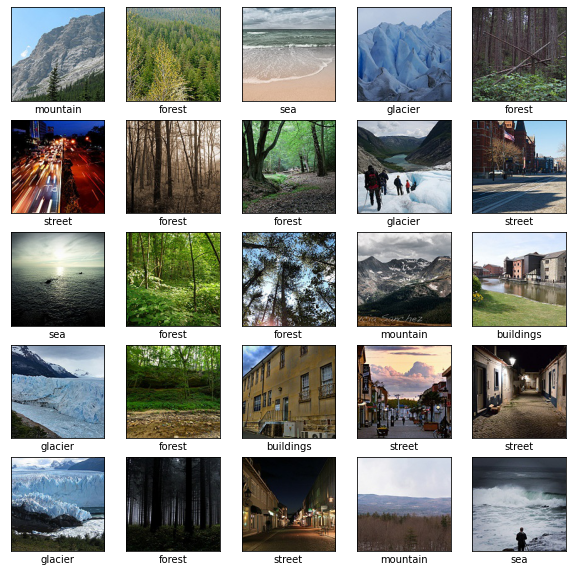

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    inx = r.choice(list(range(len(X_train))))
    plt.imshow(X_train[inx])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[inx]])
plt.show()

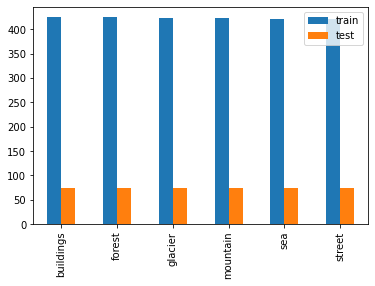

In [6]:
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()
pd.DataFrame({'train': np.array(train_counts),
                    'test': np.array(test_counts)}, 
             index=class_names).plot.bar()
plt.show()

       We can see that the number of different classifications are generally equal.

### Build the model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    # because we have 6 categories
    tf.keras.layers.Dense(6, activation='softmax')
])

In [8]:
# explaination:
# I choose adam as optimal algorithm
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 165888)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                5308448   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,318,790
Trainable params: 5,318,790
Non-trainable params: 0
______________________________________________

In [9]:
try:
    os.mkdir('Model')
except:
    pass

filepath = 'Model/convnet' + "_epoch-{epoch:02d}-loss-{loss:.4f}-.hdf5"
checkPoint = ModelCheckpoint(filepath, monitor='loss',verbose=0, save_best_only=True, mode='min')
network = model.fit(x=X_train, y=y_train, batch_size=128, epochs=8,
                    verbose=1,callbacks=[checkPoint], validation_split=0.2)

Train on 2033 samples, validate on 509 samples
Epoch 1/8
2033/2033 [==============================] - 76s 37ms/sample - loss: 2.1780 - accuracy: 0.3010 - val_loss: 1.4746 - val_accuracy: 0.4538
Epoch 2/8
2033/2033 [==============================] - 75s 37ms/sample - loss: 1.3161 - accuracy: 0.4963 - val_loss: 1.1520 - val_accuracy: 0.5540
Epoch 3/8
2033/2033 [==============================] - 75s 37ms/sample - loss: 0.9902 - accuracy: 0.6252 - val_loss: 1.0924 - val_accuracy: 0.5972
Epoch 4/8
2033/2033 [==============================] - 75s 37ms/sample - loss: 0.7795 - accuracy: 0.7201 - val_loss: 1.0154 - val_accuracy: 0.6248
Epoch 5/8
2033/2033 [==============================] - 76s 37ms/sample - loss: 0.5863 - accuracy: 0.7973 - val_loss: 0.9380 - val_accuracy: 0.6562
Epoch 6/8
2033/2033 [==============================] - 76s 37ms/sample - loss: 0.4444 - accuracy: 0.8534 - val_loss: 0.9815 - val_accuracy: 0.6405
Epoch 7/8
2033/2033 [==============================] - 77s 38ms/sample 

In [10]:
def history_plot(convnet):
    fig = plt.figure(figsize=(14,7))
    # plot accuracy
    plt.subplot(221)
    plt.plot(convnet.history['accuracy'], 'o--', label='train_acc')
    plt.plot(convnet.history['val_accuracy'], 'o--', label='val_acc')
    plt.title('Accuracy Plot train v.s. val')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    # plot loss
    plt.subplot(222)
    plt.plot(convnet.history['loss'], 'o--', label='train_loss')
    plt.plot(convnet.history['val_loss'], 'o--', label='val_loss')
    plt.title('Loss Plot train v.s. val')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

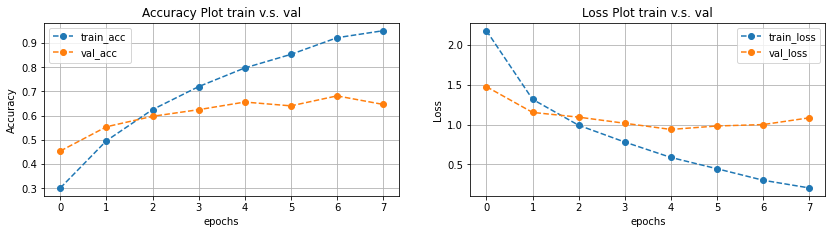

In [11]:
#loss, accuracy, val_loss, val_accuracy
history_plot(network)

> Based on the accuracy and loss plot. I observe overfitting phenomenon on the model. Because in Accuracy Plot, the train error is keep clossing to 100%, but the validation accuracy is stop improving and converge to about 70% and began to decrease as epochs increase.
> Also, The trainset's loss keep decreasing but the validation set's loss doesn't change too much and even began to increase.
> So I assume the model is overfit.

- Because this line is print too much of '=', so ignore in the html export.
```python
score = model.evaluate(X_test, y_test)
```

In [12]:
score = model.evaluate(X_test, y_test, verbose=0)
print("The test set accuracy is : ", round(score[1]*100, 3), '%')

The test set accuracy is :  68.151 %


In [13]:
y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(i) for i in y_pred], dtype='int32')

### confusion matrix and conclusion

In [14]:
cfMatrix = confusion_matrix(y_test, y_pred)
print(cfMatrix)

[[34  2  7  0 10 22]
 [ 0 68  0  0  2  5]
 [ 2  0 48  2 22  0]
 [ 2  1  4 34 33  1]
 [ 2  0  6  3 63  1]
 [ 6  4  3  0  3 59]]


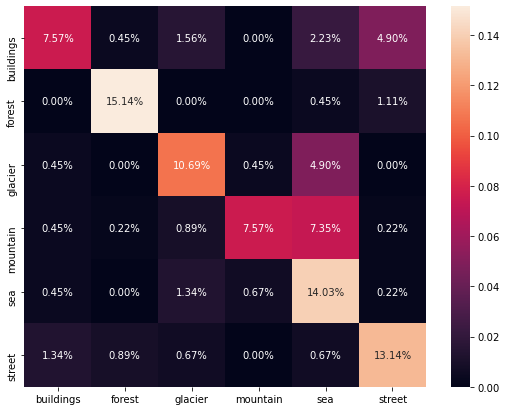

In [15]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cfMatrix/np.sum(cfMatrix), annot=True, xticklabels=class_names, yticklabels=class_names,ax=ax,
            fmt='.2%')
plt.show()

from confusion matrix

### check severl misslabeled pictures

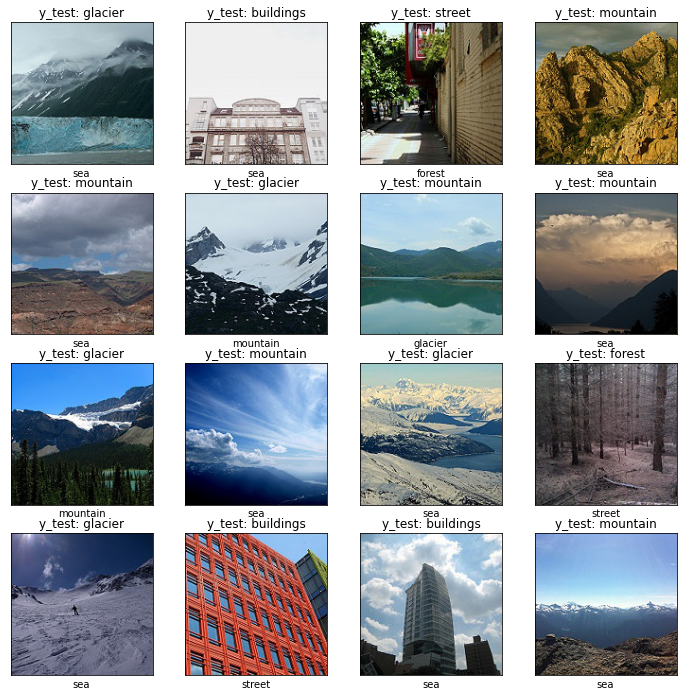

In [16]:
false_inx = np.argwhere(y_test != y_pred).squeeze()
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[false_inx[i]])
    plt.title("y_test: "+class_names[y_test[false_inx[i]]])
    plt.xlabel(class_names[y_pred[false_inx[i]]])
plt.show()

### Exploration on improving the model one step more!

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vggModel = VGG16(weights='imagenet', include_top=False)

In [18]:
train_features = vggModel.predict(X_train)
test_features = vggModel.predict(X_test)

In [19]:
n_train, f1, f2, f3 = train_features.shape
n_test, f1, f2, f3 = test_features.shape
totalDim = f1 * f2 * f3

In [20]:
train_features.shape, test_features.shape

((2542, 4, 4, 512), (449, 4, 4, 512))

In [21]:
model_vgg = tf.keras.Sequential()
model_vgg.add(tf.keras.layers.Flatten(input_shape=(f1, f2, f3)))
model_vgg.add(tf.keras.layers.Dense(32, activation='relu'))
model_vgg.add(tf.keras.layers.Dense(6, activation='softmax'))
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# set the condition of the early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, min_delta=.001, mode='min')
#convnet = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=1/5, 
#                    callbacks=[early_stopping])

vggNet = model_vgg.fit(train_features, y_train, epochs=10, validation_split=1/5, callbacks=[early_stopping])

Train on 2033 samples, validate on 509 samples
Epoch 1/10
2033/2033 [==============================] - 78s 38ms/sample - loss: 0.2238 - accuracy: 0.9341 - val_loss: 1.2186 - val_accuracy: 0.6267
Epoch 2/10
2033/2033 [==============================] - 78s 38ms/sample - loss: 0.1362 - accuracy: 0.9715 - val_loss: 1.2657 - val_accuracy: 0.6444
Epoch 3/10
2033/2033 [==============================] - 78s 38ms/sample - loss: 0.0869 - accuracy: 0.9813 - val_loss: 1.2223 - val_accuracy: 0.6680
Epoch 4/10
2033/2033 [==============================] - 78s 38ms/sample - loss: 0.0358 - accuracy: 0.9951 - val_loss: 1.2009 - val_accuracy: 0.6621
Epoch 5/10
2033/2033 [==============================] - 79s 39ms/sample - loss: 0.0220 - accuracy: 0.9980 - val_loss: 1.3570 - val_accuracy: 0.6483
Epoch 6/10
2033/2033 [==============================] - 79s 39ms/sample - loss: 0.0160 - accuracy: 0.9990 - val_loss: 1.3928 - val_accuracy: 0.6778
Epoch 7/10
2033/2033 [==============================] - 79s 39ms/

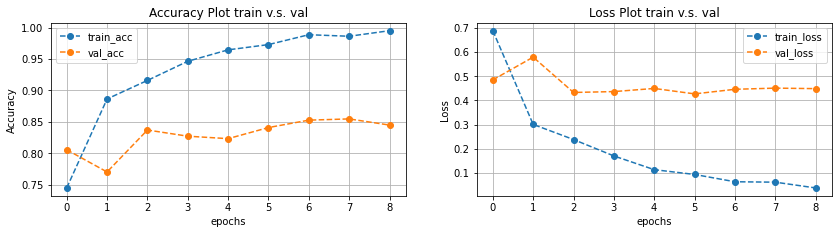

In [23]:
history_plot(vggNet)

In [24]:
score = model_vgg.evaluate(test_features, y_test, verbose=0)

In [25]:
print("Test set accuracy: ", round(score[1]*100, 3), "%\n")

Test set accuracy:  87.305 %



- This improve the model performance a lot!
> **Reference:**
    https://arxiv.org/pdf/1409.1556.pdf
> The VGG16 Algorithm is a convolution network essentially.
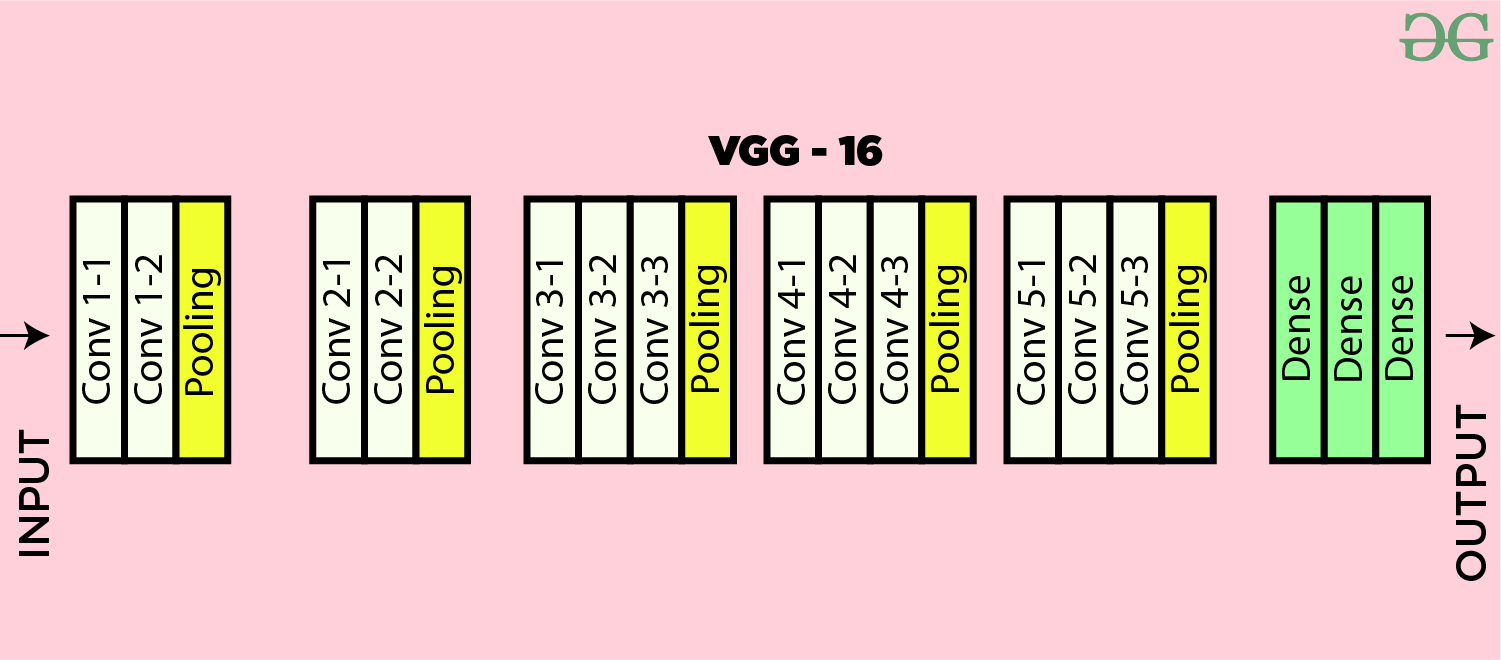

In [26]:
X_train.shape, test_features.shape

((2542, 150, 150, 3), (449, 4, 4, 512))

    - An input shape image (150* 150* 3) will be transfer to (a * b * 512) output, the a and b is depend on the first 2 dimensions of origin input shape. And the information of the image will be highly extracted abstractly.
    - In order to confirm whether VGG16 successfully extract the feature of the picture, I use PCA to decompose the values into 2 dimensions and create the plots. So I can found the eigenvectors appers hierachical layers.
    - Points of different classes have different centroids.

### Problem 2

In [2]:
df = pd.read_csv("./admData20.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ExpStartDate      147 non-null    object
 1   AdmittedNum       147 non-null    int64 
 2   AppliedNum        147 non-null    int64 
 3   WeeksBeforeStart  147 non-null    int64 
 4   Budget            147 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 5.9+ KB
None


,ExpStartDate,AdmittedNum,AppliedNum,WeeksBeforeStart,Budget
0,10/29/2018,3,61,10,87
1,10/29/2018,7,84,9,87
2,10/29/2018,10,90,8,87
3,10/29/2018,24,118,7,87
4,10/29/2018,39,132,6,87


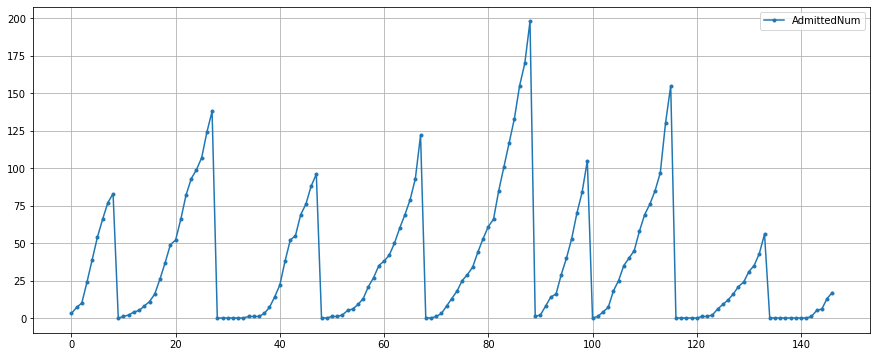

In [3]:
admissions = df.loc[:, 'AdmittedNum'].values
plt.figure(figsize=(15,6))
plt.plot(admissions, '.-',label='AdmittedNum')
plt.grid()
plt.legend()
plt.show()

- The objective of the probelem is to predict the accumulative number of admissions. So we store all the admittedNum values.

### train test split
---
    The datasets is small scale,
    and keras provide the built-in cross-validation functions, so I didn't split the validation set.

In [4]:
trainPortion = round(admissions.shape[0] * .7)
trainData = admissions[:trainPortion]
testData = admissions[trainPortion :]
len(trainData), len(testData)

(103, 44)

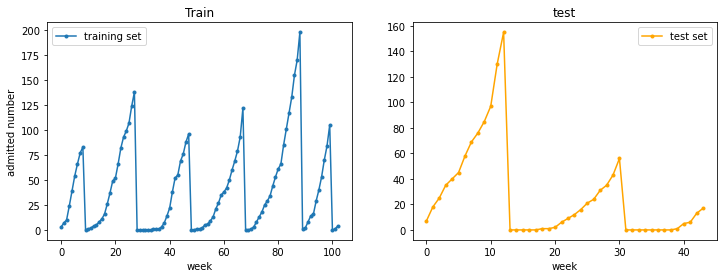

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(range(trainData.shape[0]), trainData,'.-',label='training set')
plt.title('Train')
plt.xlabel('week')
plt.ylabel('admitted number')
plt.legend()

plt.subplot(122)
plt.plot(range(testData.shape[0]), testData,'.-', color='orange', label='test set')
plt.title('test')
plt.xlabel('week')
plt.legend()

plt.show()

In [6]:
sc = MinMaxScaler(feature_range=(0, 1))

In [7]:
trainData = trainData.reshape(-1, 1)
testData = testData.reshape(-1, 1)

sc.fit(trainData)
trainNorm = sc.transform(trainData)
testNorm = sc.transform(testData)

In [8]:
def createSeq(dataset, look_back=5, foresight=4):
    X , Y = [], []
    for i in range(len(dataset) - look_back - foresight):
        obs = dataset[i:(i+look_back), 0]
        X.append(obs)
        Y.append(dataset[i+(look_back + foresight), 0])
    return np.array(X), np.array(Y)

### Create Sequences
---
    We want to predict the future weeks accumulative admissions based on the previous values. So, we need to create different sequences to meet the requirements.

In [9]:
X_train = list()
Y_train = list()
X_test = list()
Y_test = list()

for Fsight in range(5):
    X_ , y_ = createSeq(trainNorm, foresight=Fsight)
    tx, ty = createSeq(testNorm, foresight=Fsight)
    
    X_train.append(X_.reshape(X_.shape[0], X_.shape[1], 1))
    Y_train.append(y_)
    X_test.append(tx.reshape(tx.shape[0], tx.shape[1], 1))
    Y_test.append(ty)

In [10]:
X_train[0].shape, Y_train[0].shape, X_test[0].shape, Y_test[0].shape

((98, 5, 1), (98,), (39, 5, 1), (39,))

In [11]:
def plot_history(network):
    loss = network.history.get('loss')
    mae = network.history.get('mean_absolute_error')
    val_loss = network.history.get('val_loss')
    val_mae = network.history.get('val_mean_absolute_error')
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.plot(loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.legend()
    plt.title('Loss Comparison')
    
    plt.subplot(132)
    plt.plot(loss, label='train mae')
    plt.plot(val_loss, label='val mae')
    plt.legend()
    plt.title('Mean Absolute Error Comparison')
    
def my_predict(model, i):
    y_pred = model.predict(X_test[i])
    plt.subplot(133)
    plt.plot(sc.inverse_transform(Y_test[i].reshape(-1,1)), label='y_test')
    plt.plot(sc.inverse_transform( y_pred ), label='y_pred')
    plt.title('predict week = %d' % (i+1))
    plt.legend()

### LSTM model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [18]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(5, 1), dropout=0.1, recurrent_dropout=0.1))
lstm_model.add(Flatten())
lstm_model.add(Dense(1, activation='linear'))
lstm_model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3, min_delta=.001, mode='min')

When Foresight =  0 : 

MAE:  0.07273413 
 -------------------------------------------------- 

When Foresight =  1 : 

MAE:  0.10420752 
 -------------------------------------------------- 

When Foresight =  2 : 

MAE:  0.14818212 
 -------------------------------------------------- 

When Foresight =  3 : 

MAE:  0.15326518 
 -------------------------------------------------- 

When Foresight =  4 : 

MAE:  0.16045482 
 -------------------------------------------------- 



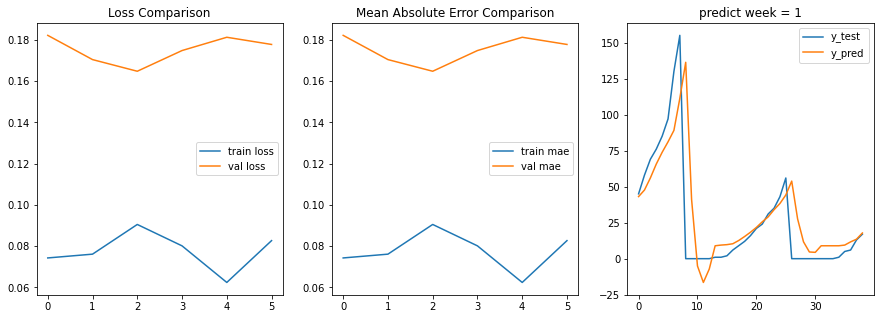

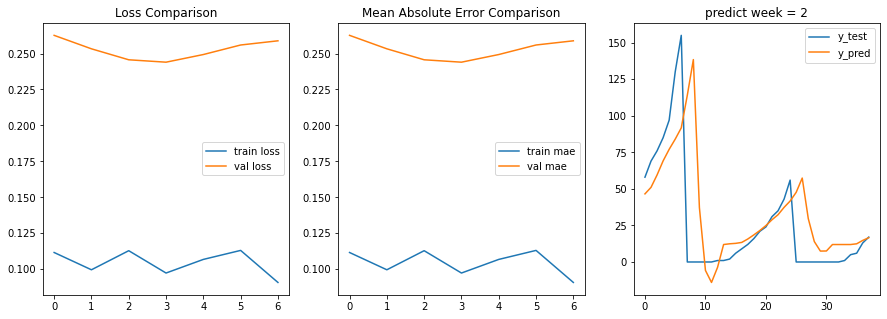

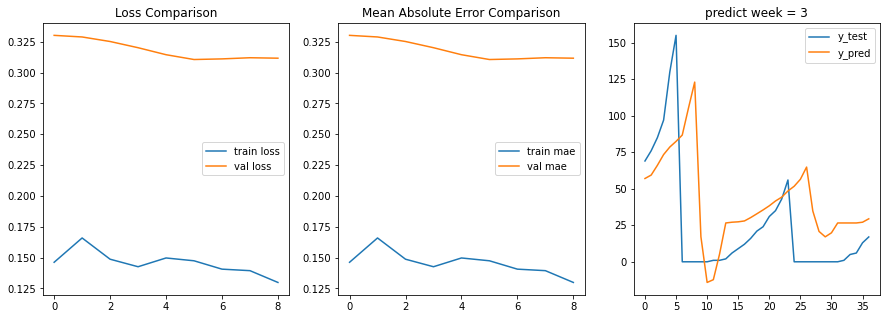

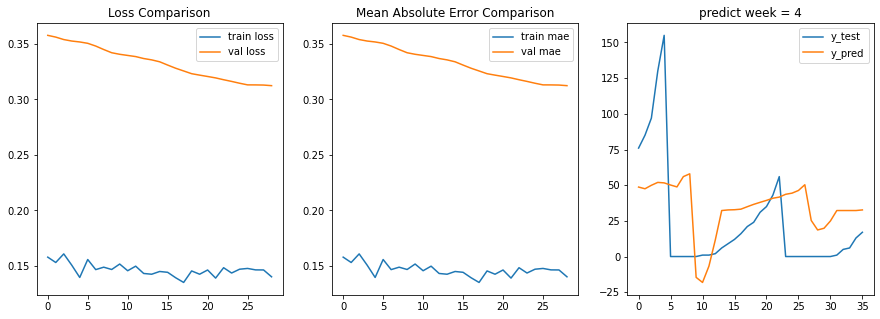

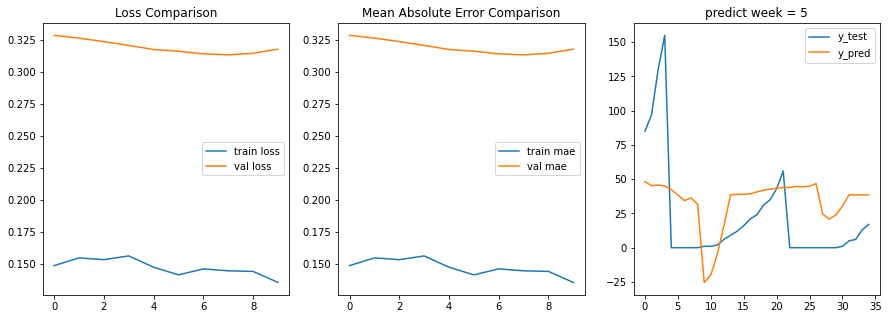

In [22]:
for Fsight in range(5):
    lstm = lstm_model.fit(X_train[Fsight], Y_train[Fsight], epochs=100, 
                     validation_split=.2, verbose=0, callbacks=[early_stopping])
    LSTM_score = lstm_model.evaluate(X_test[Fsight], Y_test[Fsight], verbose=0)
    
    # Report
    print('When Foresight = ', Fsight, ': \n')
    print('MAE: ',LSTM_score[1], '\n', '-'*50, '\n')
    
    
    # Plot
    plot_history(lstm)
    my_predict(lstm_model, Fsight)

    As the plots illustrated. As we set the foresight increase, the model performs worse. This conclusion is intuitive. The best model is when foresight = 0, which means when we want to predict the closest 1 week in the future, the result is most predictable.
    Also, we found that the model prediction also has one unit delay.

### GRU model

In [16]:
gru_model = Sequential()
gru_model.add(GRU(32, input_shape=(5, 1), dropout=0.1, recurrent_dropout=0.1))
gru_model.add(Flatten())
gru_model.add(Dense(1, activation='linear'))
gru_model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


### model training

When Foresight =  0 : 

MAE:  0.06324228 
 -------------------------------------------------- 

When Foresight =  1 : 

MAE:  0.09967844 
 -------------------------------------------------- 

When Foresight =  2 : 

MAE:  0.13706182 
 -------------------------------------------------- 

When Foresight =  3 : 

MAE:  0.15788442 
 -------------------------------------------------- 

When Foresight =  4 : 

MAE:  0.1569613 
 -------------------------------------------------- 



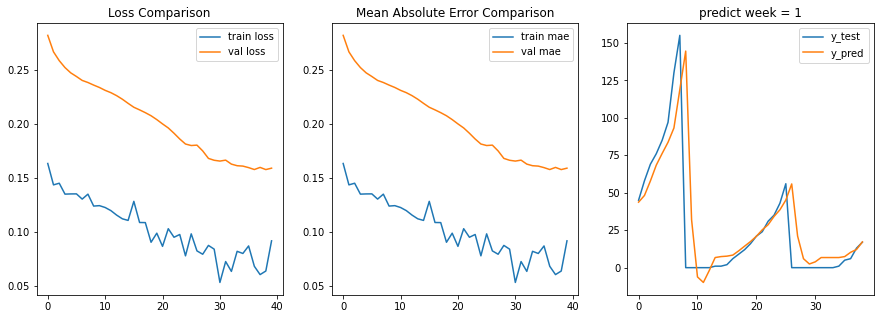

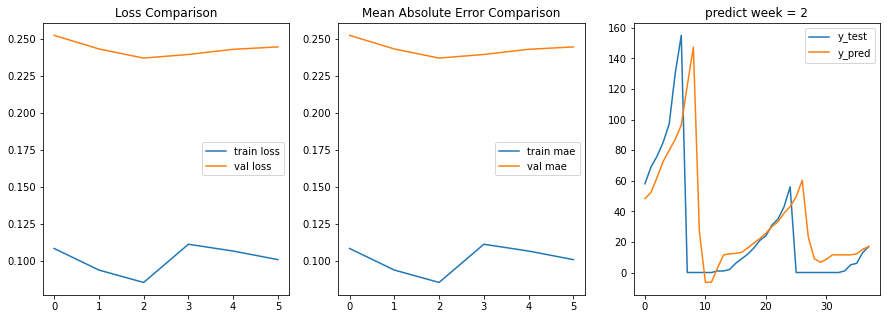

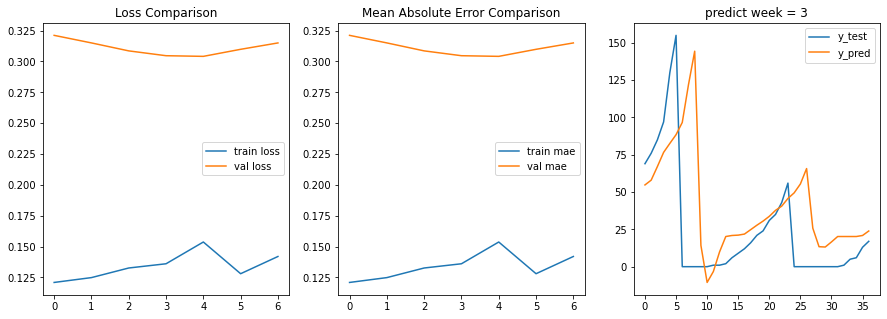

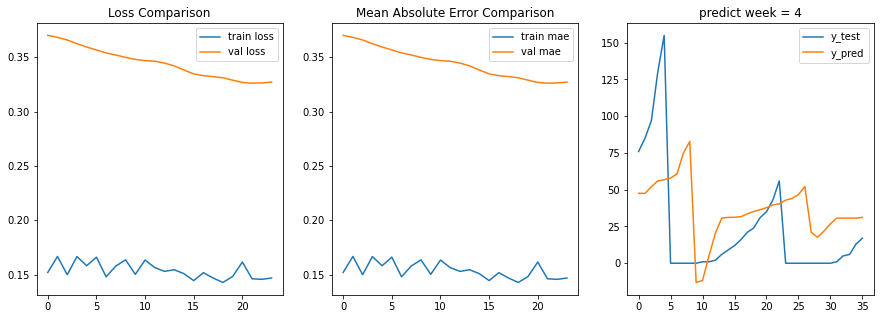

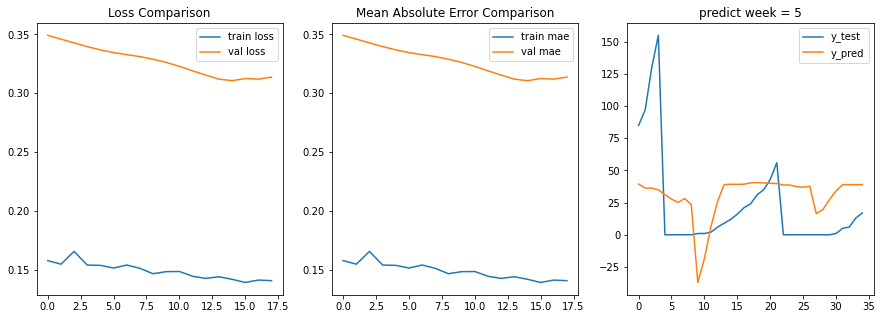

In [17]:
for Fsight in range(5):
    gru = gru_model.fit(X_train[Fsight], Y_train[Fsight], epochs=100, 
                     validation_split=.2, verbose=0, callbacks=[early_stopping])
    GRU_score = gru_model.evaluate(X_test[Fsight], Y_test[Fsight], verbose=0)
    
    # Report
    print('When Foresight = ', Fsight, ': \n')
    print('MAE: ',GRU_score[1], '\n', '-'*50, '\n')
    
    
    # Plot
    plot_history(gru)
    my_predict(gru_model, Fsight)

### 2.
---
    Create a 1d convolutional network model.  Explore if stacking lstm or grulayers helps with the performance.
    (a)  Report the MAE of the test set on your best model.
    (b)  Plot the loss curves for training and validation sets.

### directly using conv1d
---
    Because when foresight is 0, we predict the admissions of future 1 weeks, the model performs best. So here we  only compare the model when foresight = 0.

In [18]:
conv_model = Sequential()
conv_model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(5,1)))
conv_model.add(tf.keras.layers.MaxPooling1D())
conv_model.add(Flatten())
conv_model.add(Dense(1, activation='linear'))
conv_model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])
conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 32)             128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [19]:
network = conv_model.fit(X_train[0], Y_train[0], epochs=100, 
                     validation_split=.2, verbose=0, callbacks=[early_stopping])
conv_model.evaluate(X_test[0], Y_test[0])

39/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.11834240150757325, 0.1183424]

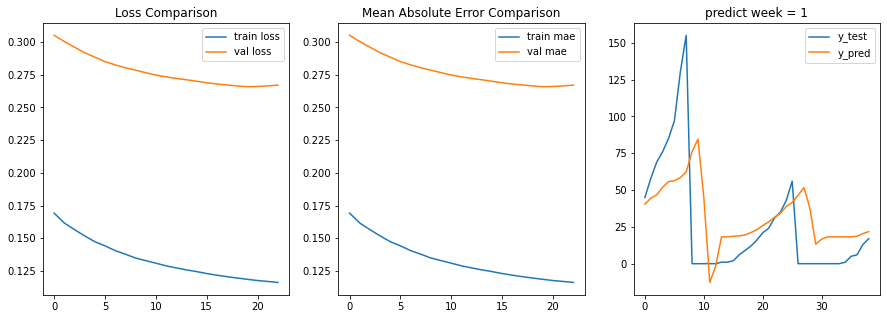

In [21]:
plot_history(network)
my_predict(conv_model, 0)

### stack with LSTM

In [23]:
# stack with conv1d
convlstm_model = Sequential()
convlstm_model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(5,1)))
convlstm_model.add(tf.keras.layers.MaxPooling1D())
convlstm_model.add(Flatten())
convlstm_model.add(tf.keras.layers.RepeatVector(3))
convlstm_model.add(LSTM(64,activation='relu'))
convlstm_model.add(Dense(1, activation='linear'))
convlstm_model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])
convlstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 3, 32)             128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 25,025
Trainable params: 25,025
Non-trainable params: 0
__________________________________________________

In [24]:
network = convlstm_model.fit(X_train[0], Y_train[0], epochs=100, 
                     validation_split=.2, verbose=0, callbacks=[early_stopping])
convlstm_model.evaluate(X_test[0], Y_test[0])

39/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0788498896245773, 0.07884989]

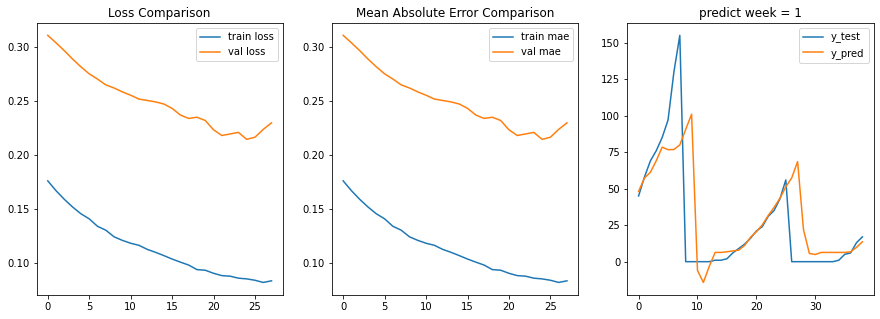

In [25]:
plot_history(network)
my_predict(convlstm_model, 0)

    Doesn't improve too much

### stack with GRU

In [26]:
# stack with GRU
convGru_model = Sequential()
convGru_model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(5,1)))
convGru_model.add(tf.keras.layers.MaxPooling1D())
convGru_model.add(Flatten())
convGru_model.add(tf.keras.layers.RepeatVector(3))
convGru_model.add(GRU(64,activation='relu'))
convGru_model.add(Dense(1, activation='linear'))
convGru_model.compile(loss='mae', optimizer='adam', metrics=['mean_absolute_error'])
convGru_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 3, 32)             128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 32)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
__________________________________________________

In [27]:
network = convGru_model.fit(X_train[0], Y_train[0], epochs=100, 
                     validation_split=.2, verbose=0, callbacks=[early_stopping])
convGru_model.evaluate(X_test[0], Y_test[0])

39/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.07819091805662864, 0.07819092]

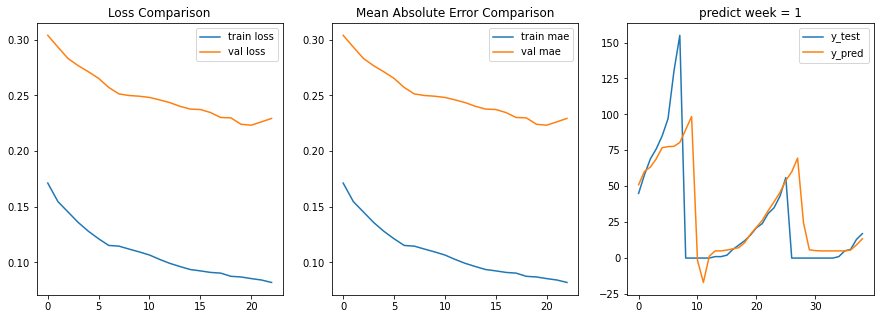

In [28]:
plot_history(network)
my_predict(convGru_model, 0)

### Regular Neural Netwok
---
    Explaination:
    In this case, I believe the other features also destribute the prediction of 'AdmittedNum'. So I choose to use all the features in the data.

In [29]:
myModel = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(5,1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
myModel.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mean_absolute_error']
)
myModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5, 128)            256       
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 5, 64)             8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                5136      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [30]:
network = myModel.fit(X_train[0], Y_train[0], epochs=100, 
                     validation_split=.2, verbose=0, callbacks=[early_stopping])
myModel.evaluate(X_test[0], Y_test[0])

39/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06003537704833807, 0.060035374]

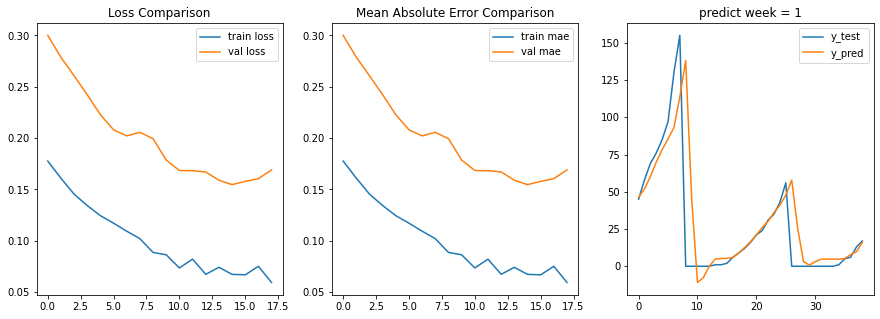

In [31]:
plot_history(network)
my_predict(myModel, 0)

## Thinking:
### what about consider the other features in the model?

In [23]:
myData = df.copy()
myData.head()

,ExpStartDate,AdmittedNum,AppliedNum,WeeksBeforeStart,Budget
0,10/29/2018,3,61,10,87
1,10/29/2018,7,84,9,87
2,10/29/2018,10,90,8,87
3,10/29/2018,24,118,7,87
4,10/29/2018,39,132,6,87


In [24]:
myData.corr()

,AdmittedNum,AppliedNum,WeeksBeforeStart,Budget
AdmittedNum,1.000000,0.884202,-0.798491,0.284216
AppliedNum,0.884202,1.000000,-0.820704,0.300805
WeeksBeforeStart,-0.798491,-0.820704,1.000000,0.108601
Budget,0.284216,0.300805,0.108601,1.000000


- We can see that except Budget, the AdmittedNum seems related to both AppliedNumber  weeksBeforeStart

In [26]:
X = np.array(myData[['AppliedNum', 'WeeksBeforeStart']])
y = np.array(myData['AdmittedNum'])

In [27]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape

((102, 2), (45, 2))

In [28]:
sc.fit(X_train)
trainNormX =sc.transform(X_train)
testNormX =sc.transform(X_test)

In [29]:
sc.fit(y_train.reshape(-1,1))
trainNormY = sc.transform(y_train.reshape(-1,1))
testNormY = sc.transform(y_test.reshape(-1, 1))

In [37]:
regModel = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu', input_dim=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])
regModel.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mean_absolute_error']
)
regModel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               384       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [44]:
network = regModel.fit(trainNormX, trainNormY, epochs=100, 
                     validation_split=.2, verbose=0)
regModel.evaluate(testNormX, testNormY)

45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.049712265655398366, 0.049712267]

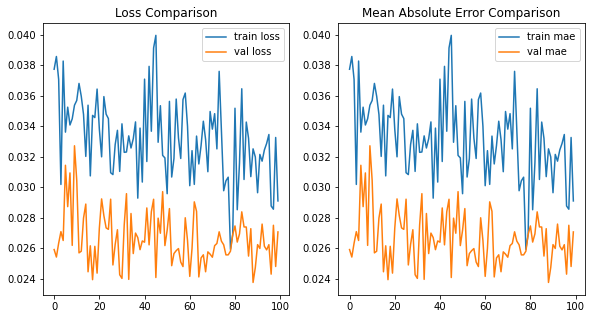

In [45]:
plot_history(network)

In [46]:
y_pred = regModel.predict(testNormX)

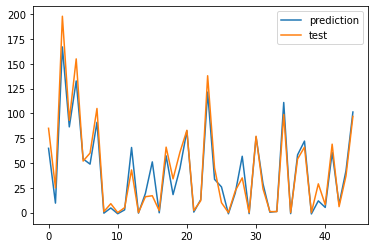

In [47]:
plt.plot(sc.inverse_transform(y_pred), label='prediction')
plt.plot(sc.inverse_transform(testNormY), label='test')
plt.legend()
plt.show()

### Comment

    - So when we assesed the different models by comparing their mean absolute error, and we found that the regular neural network model is as good as the LSTM and GRU model (with mean absolute error about 0.05-0.06 in this case). This may because of the more layers and more neurons.
    - Also, using conv1d directly or stack with LSTM/GRU may doesn't performs well as our expectation (their mean absolute error is about 0.1-0.2 when foresight=0).

    - However, if we consider the other features and also take the AppliedNum and WeeksBeforeStart into account. The model performs even better. (though mae is about 0.05 but the model have no delayed.)
    - So when we have more features in reality. It may improve the model performance when you have more relevant features.